In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import os, sys

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)
os.chdir("..")

2.2.3
3.4.2


In [3]:
os.getcwd()

'/Users/benschaefer/Desktop/epa141-model/final assignment'

In [4]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator, Scenario
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


In [5]:
model, _ = get_model_for_problem_formulation(2)

[IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False), IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False), IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False), IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False), IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False), IntegerParameter('EWS_DaysToThreat', 0, 1, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False), IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False), IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False), IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.3_DikeIn

In [6]:
rings = ["deventer", "zutphen"]


In [7]:
dfs = []
for ring in rings:
    with open(f"./saved_runs/directed_search/search_worst_case_{ring}.pkl", "rb") as file:
        df = pickle.load(file)
        dfs.append(df)
    


In [8]:
def categorizer(df: pd.DataFrame, col:str, label: str, thresh:int, label_cats):
    df[label] = df[col].apply(lambda x: label_cats[0] if x >= thresh else label_cats[1])

def dynamic_cost_categorizer(df: pd.DataFrame, col:str, label: str, thresh:int, label_cats ):
    df[label] = df[col].apply(lambda x: label_cats[0] if x*0.1 >= thresh else label_cats[1])

In [9]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
outcome_names = [o.name for o in model.outcomes]
outcome_names.remove("Evacuation Costs")

def thresh_viz(category, label_names):
    plt.figure(figsize=(5, 5))
    limits = parcoords.get_limits(df[outcome_names])
    limits.loc[0, outcome_names] = 0
    paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=8)
    # Define colors for each label
    label_colors = {
        # "mid": "#cccccc",  # for unlabeled/mid cases
        label_names[0]: "#ec4444",
        label_names[1]: "#2ca02c"
    }
    for label in list(label_colors.keys()):
        group = df[df[category] == label]
        print(len(group))
        color = label_colors.get(label, "#cccccc")
        paraxes.plot(group[outcome_names], color=color, lw=1, alpha=0.5, label=f"{label} ({len(group)})")

    paraxes.legend()

def combined_viz(df, categories, labels):
    combined_obj = list(zip(categories, [x[1] for x in labels]))
    print(combined_obj)
    plt.figure(figsize=(5, 5))
    limits = parcoords.get_limits(df[outcome_names])
    limits.loc[0, outcome_names] = 0
    paraxes = parcoords.ParallelAxes(limits, rot=90, fontsize=8)
    # Define colors for each label
    label_colors = {
        # "mid": "#cccccc",  # for unlabeled/mid cases
        "Not viable": "#ec4444",
        "Viable": "#2ca02c"
    }

    # crafting expression for checking
    condition = pd.Series(True, index=df.index)
    for category, label in combined_obj:
        condition &= (df[category] == label)
    
    print(condition)
    
    group = df[condition]
    print(len(group))
    color = label_colors.get("Viable", "#cccccc")
    paraxes.plot(group[outcome_names], color=color, lw=1, alpha=0.5, label=f"Financiable with low deaths({len(group)})")

    group = df[~condition]
    print(len(group))
    color = label_colors.get("Not viable", "#cccccc")
    paraxes.plot(group[outcome_names], color=color, lw=1, alpha=0.5, label=f"Costly or high death count ({len(group)})")

    paraxes.legend()


## Zutphen Visualization

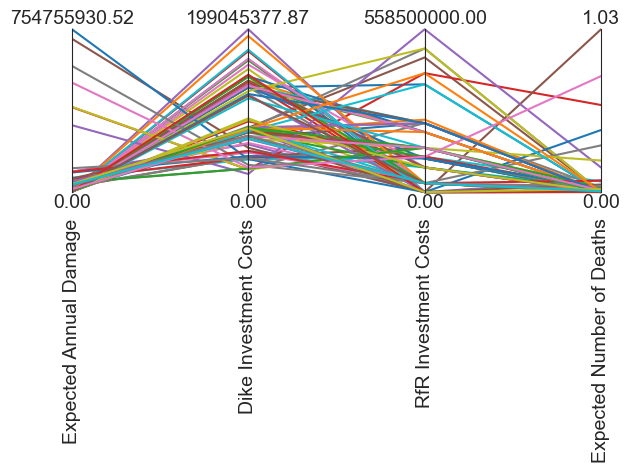

In [10]:

data = dfs[1].loc[:, outcome_names]
limits = parcoords.get_limits(data)
limits.loc[0, outcome_names] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [11]:
all_cats = ["Expected Number of Deaths", "RfR Investment Costs", "Dike Investment Costs" ]
indicators = ["Death Indicator", "RfR Cost Indicator", "Dike Cost Indicator"]
death_labels = ["High", "Low"]
cost_labels = ["Costly", "Financiable"]


In [20]:
categorizer(dfs[1], all_cats[0], "Death Indicator", 0.1, death_labels)
dynamic_cost_categorizer(dfs[1], all_cats[1], "RfR Cost Indicator", 10e6, cost_labels)
dynamic_cost_categorizer(dfs[1], all_cats[2], "Dike Cost Indicator", 30e6, cost_labels)

[('Death Indicator', 'Low'), ('RfR Cost Indicator', 'Financiable'), ('Dike Cost Indicator', 'Financiable')]
0     False
1     False
2     False
3      True
4      True
      ...  
75     True
76    False
77     True
78     True
79     True
Length: 80, dtype: bool
37
43


<Figure size 500x500 with 0 Axes>

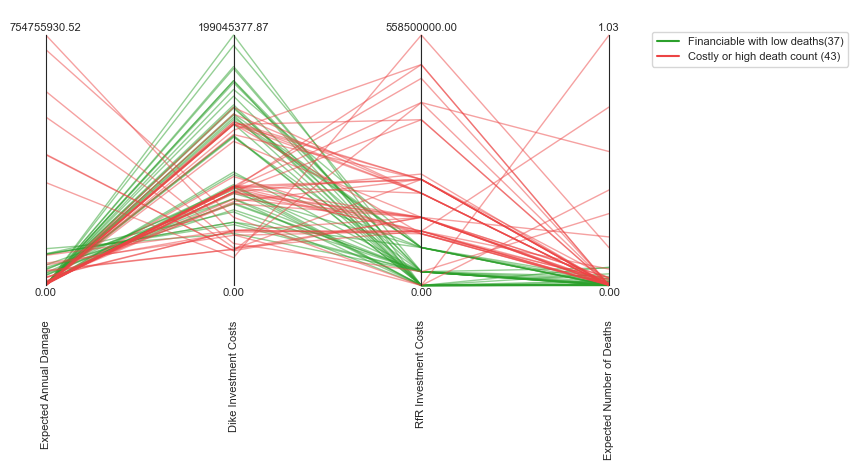

In [21]:
combined_viz(dfs[1], indicators, [death_labels, cost_labels, cost_labels])

# Zutphen Analysis

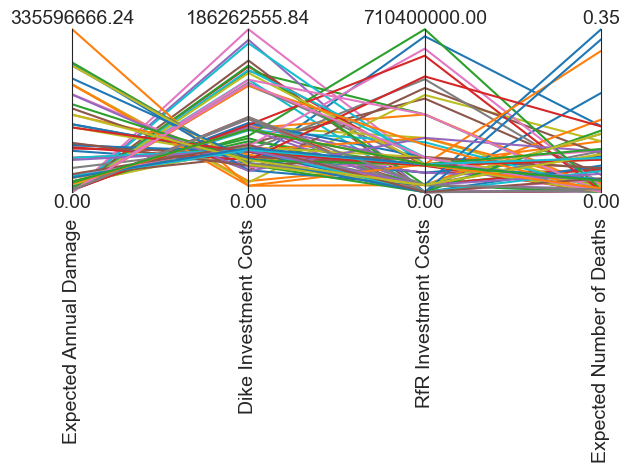

In [16]:
data = dfs[0].loc[:, outcome_names]
limits = parcoords.get_limits(data)

limits.loc[0, outcome_names] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [17]:
categorizer(dfs[0], all_cats[0], "Death Indicator", 0.1, death_labels)
dynamic_cost_categorizer(dfs[0], all_cats[1], "RfR Cost Indicator", 30e6, cost_labels)
dynamic_cost_categorizer(dfs[0], all_cats[2], "Dike Cost Indicator", 10e6, cost_labels)

[('Death Indicator', 'Low'), ('RfR Cost Indicator', 'Financiable'), ('Dike Cost Indicator', 'Financiable')]
0     False
1     False
2     False
3      True
4     False
      ...  
68     True
69     True
70     True
71     True
72     True
Length: 73, dtype: bool
39
34


<Figure size 500x500 with 0 Axes>

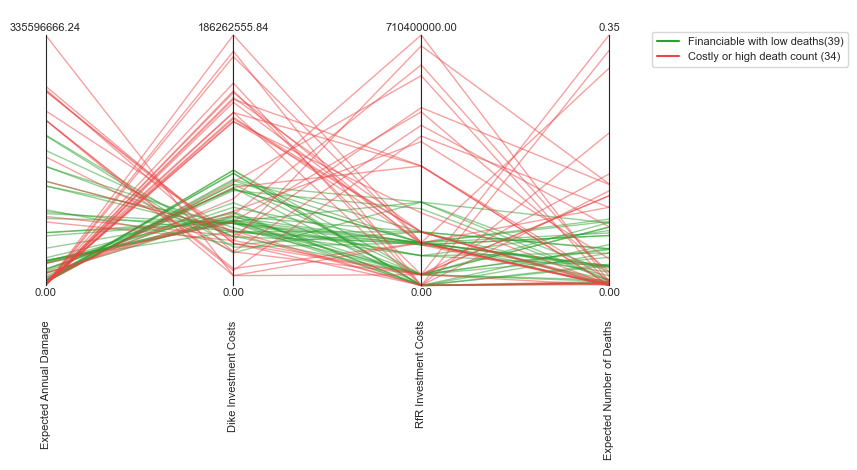

In [19]:
combined_viz(dfs[0], indicators, [death_labels, cost_labels, cost_labels])

In [41]:
# crafting expression to filter for viability

def get_viable_data(df):
    leading_labels = [ x[1] for x in [death_labels, cost_labels, cost_labels] ]
    combined_obj = list(zip(indicators, leading_labels ))
    # print(combined_obj)
    condition = pd.Series(True, index=df.index)
    for category, label in combined_obj:
        condition &= (df[category] == label)
    
    return df[condition]

In [52]:
viable_outcomes = []
for df in dfs:
    viable_outcome = get_viable_data(df)
    viable_outcomes.append(viable_outcome)
    

In [ ]:
for j in range(2):
    
    rfr_grouped = viable_outcomes[j].groupby([f"{x}_RfR 0" for x  in range(5)]).size() \
    .reset_index(name='count') \
    .sort_values(by='count', ascending=False)
    print(rfr_grouped)

    # print(f"<< {j} >>")
    # for i in range(5):
    #     print(i, ":", dfs[j][f"{i}_RfR 0"].sum() / len(dfs[j]))


   0_RfR 0  1_RfR 0  2_RfR 0  3_RfR 0  4_RfR 0  count
1        0        0        0        1        0      9
0        0        0        0        0        0      8
2        0        0        1        0        0      8
3        0        0        1        1        0      4
5        1        0        0        0        0      3
6        1        0        1        0        0      3
7        1        0        1        1        0      3
4        0        1        0        0        0      1
   0_RfR 0  1_RfR 0  2_RfR 0  3_RfR 0  4_RfR 0  count
0        0        0        0        0        0     16
1        0        0        1        0        0     14
2        1        0        0        0        0      7


In [ ]:
# Deventer favorable scenario without RfR

In [60]:
viable_outcomes[0]
[f"{x}_RfR 0" for x  in range(5)]

cols = [f"{x}_RfR 0" for x in range(5)]

# Boolean mask where all those columns are 0
mask = (viable_outcomes[0][cols] == 0).all(axis=1)

# Get the first matching row (as a Series)
first_match = viable_outcomes[0][mask].iloc[0]

first_match.to_csv("./saved_runs/scenarios_for_robustness/deventer_no_dikes.csv")

In [ ]:
# Zutphen Room for the river

In [ ]:
df = viable_outcomes[1]
cols = [f"{x}_RfR 0" for x in range(5)]

# Build condition: only "2_RfR 0" is 1, rest are 0
mask = (df[cols] == [0, 0, 1, 0, 0]).all(axis=1)

# Get the first match
first_match = df[mask].iloc[0]

first_match.to_csv("./saved_runs/scenarios_for_robustness/zutphen_rfr2.csv")

0_RfR 0                                    0
1_RfR 0                                    0
2_RfR 0                                    1
3_RfR 0                                    0
4_RfR 0                                    0
EWS_DaysToThreat                           1
A.1_DikeIncrease 0                         0
A.2_DikeIncrease 0                         0
A.3_DikeIncrease 0                         8
A.4_DikeIncrease 0                         6
A.5_DikeIncrease 0                         6
Expected Annual Damage        5573607.391033
Dike Investment Costs        90145168.283062
RfR Investment Costs              30700000.0
Expected Number of Deaths           0.001517
Death Indicator                          Low
RfR Cost Indicator               Financiable
Dike Cost Indicator              Financiable
Name: 8, dtype: object
